In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


# Dataset

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

def downloadFlowerData():
    '''Download flower detection dataset from alxmamaev/flowers-recognition.'''
    api = KaggleApi()
    api.authenticate()
    try:
        api.dataset_download_files('alxmamaev/flowers-recognition', path='data/',quiet=False) #do not forget to add kaggle.json into Users/.kaggle/
    except:
        return -1
    return 0

def checkDataset():
    # Check dataset zip file
    if(not os.path.exists('data/flowers-recognition.zip')):
        print("flowers dataset not found, downloading from kaggle")
        if(downloadFlowerData()==-1):
            print("Downloading dataset fail, please check kaggle.json is correct or try again with stable internet connection")
            os.remove('data/flowers-recognition.zip')
            quit()
    
    # Extract Data
    if(not os.path.exists('data/flowers/')):
        print("Extracting flowers-recognition.zip")
        with ZipFile('data/flowers-recognition.zip') as file:
            file.extractall('data/')
        print("Done")

import os, fnmatch
from PIL import Image
import numpy as np
import random

def convertToGrayscale(imageRGB):
    """return grayscale conversion of RGB image"""
    # https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html
    # Basically  Grayscale = 0.299⋅R + 0.587⋅G + 0.114⋅B
    # We could easily vectorized and just do the dot product of imageRGB with [0.299,0.587,0.114]

    imageGrayscale = np.dot(imageRGB, [0.299,0.587,0.114])

    return imageGrayscale


def getImages(label, n=100):
    """return list of (default 100) images for a given label"""

    # Check Dataset
    checkDataset()

    # Try and get path
    path = "data/flowers/" + label.lower()
    if(not os.path.exists(path)):
        print("No label found")
        return -1
    
    # Get all images address
    allFiles = fnmatch.filter(os.listdir(path), '*.jpg')
    random.seed(42)
    usedFiles = random.sample(allFiles, n) # get 100 samples from allFiles

    # Read the data into numpy array
    imagesRGB = []
    for file in usedFiles:
        img = Image.open(path+'/'+file)
        img = img.resize((320,240), Image.ANTIALIAS)
        imagesRGB.append(np.asarray(img))
    
    imagesRGB = np.asarray(imagesRGB) #(n, 240, 320, 3)

    return imagesRGB

def preprocessImage(images): 
    """return np.array to be loaded into a model,
    flatten dimension (100, 240, 320) -> (100, 76800), and 
    Normalize data value from int [0, 255] -> float [0,1]"""

    x = images.reshape(*images.shape[:1], -1) #(100, 76800)
    x = x/255.0
    return x

# CNN Model

# Get Dataset

In [ ]:
labels = ['Sunflower', 'Dandelion', 'Rose']
n_data = 100

X = None
y = None
for i in range(len(labels)):
    if(X is None):
        X = getImages(labels[i], n=n_data)
    else:
        X = np.append(X, getImages(labels[i], n=n_data), axis=0)

    if(y is None):
        y = np.full(shape=n_data,fill_value=i,dtype=np.int)
    else:
        y = np.append(y, np.full(shape=n_data,fill_value=i,dtype=np.int), axis=0)

flowers dataset not found, downloading from kaggle


  1%|          | 5.00M/450M [00:00<00:10, 45.8MB/s]

100%|██████████| 450M/450M [00:03<00:00, 130MB/s]



Extracting flowers-recognition.zip
Done


In [ ]:
from sklearn.model_selection import train_test_split
n_values = np.max(y) + 1
y = np.eye(n_values)[y]
print(y.shape)
X = X/255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

(300, 3)


## Model 1


In [ ]:
import tensorflow as tf

In [ ]:
model21 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(1),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Dense(3, activation='softmax')
])
model21.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

history21 = model21.fit(X_train, y_train, batch_size=5, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
48/48 [==============================] - 11s 209ms/step - loss: 8.3761 - acc: 0.4708 - val_loss: 2.0172 - val_acc: 0.6667
Epoch 2/30
48/48 [==============================] - 9s 198ms/step - loss: 1.4834 - acc: 0.6250 - val_loss: 1.0561 - val_acc: 0.6833
Epoch 3/30
48/48 [==============================] - 9s 196ms/step - loss: 0.9192 - acc: 0.6458 - val_loss: 1.0009 - val_acc: 0.6667
Epoch 4/30
48/48 [==============================] - 9s 197ms/step - loss: 0.8697 - acc: 0.6917 - val_loss: 0.8406 - val_acc: 0.6000
Epoch 5/30
48/48 [==============================] - 9s 196ms/step - loss: 0.7522 - acc: 0.6792 - val_loss: 1.1236 - val_acc: 0.6000
Epoch 6/30
48/48 [==============================] - 9s 197ms/step - loss: 0.8362 - acc: 0.6875 - val_loss: 0.8072 - val_acc: 0.6500
Epoch 7/30
48/48 [==============================] - 9s 197ms/step - loss: 0.7327 - acc: 0.6917 - val_loss: 0.7740 - val_acc: 0.6167
Epoch 8/30
48/48 [==============================] - 10s 198ms/step - loss: 

## Model 2

In [ ]:
model22 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(1),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(3, activation='softmax')
])
model22.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

history22 = model22.fit(X_train, y_train, batch_size=5, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
48/48 [==============================] - 11s 219ms/step - loss: 29.9053 - acc: 0.4208 - val_loss: 6.5712 - val_acc: 0.4333
Epoch 2/30
48/48 [==============================] - 10s 213ms/step - loss: 3.3082 - acc: 0.5458 - val_loss: 3.2591 - val_acc: 0.6500
Epoch 3/30
48/48 [==============================] - 10s 210ms/step - loss: 1.6613 - acc: 0.5958 - val_loss: 1.2245 - val_acc: 0.6667
Epoch 4/30
48/48 [==============================] - 10s 209ms/step - loss: 1.0764 - acc: 0.6167 - val_loss: 0.9919 - val_acc: 0.6333
Epoch 5/30
48/48 [==============================] - 10s 208ms/step - loss: 0.9055 - acc: 0.6792 - val_loss: 1.0756 - val_acc: 0.6000
Epoch 6/30
48/48 [==============================] - 10s 209ms/step - loss: 0.8881 - acc: 0.6333 - val_loss: 0.9315 - val_acc: 0.6667
Epoch 7/30
48/48 [==============================] - 10s 209ms/step - loss: 0.8291 - acc: 0.6917 - val_loss: 0.8508 - val_acc: 0.6500
Epoch 8/30
48/48 [==============================] - 10s 210ms/step -

## Model 3

In [ ]:
model23 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(1),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(3, activation='softmax')
])
model23.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

history23 = model23.fit(X_train, y_train, batch_size=5, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
48/48 [==============================] - 17s 319ms/step - loss: 46.0684 - acc: 0.4250 - val_loss: 11.8868 - val_acc: 0.5167
Epoch 2/30
48/48 [==============================] - 12s 243ms/step - loss: 2.5285 - acc: 0.5708 - val_loss: 1.1029 - val_acc: 0.4833
Epoch 3/30
48/48 [==============================] - 12s 242ms/step - loss: 1.2571 - acc: 0.5542 - val_loss: 0.9741 - val_acc: 0.5667
Epoch 4/30
48/48 [==============================] - 12s 241ms/step - loss: 1.0226 - acc: 0.5083 - val_loss: 0.9769 - val_acc: 0.5667
Epoch 5/30
48/48 [==============================] - 12s 241ms/step - loss: 0.8840 - acc: 0.6333 - val_loss: 0.8573 - val_acc: 0.6000
Epoch 6/30
48/48 [==============================] - 12s 241ms/step - loss: 0.8968 - acc: 0.6000 - val_loss: 0.8746 - val_acc: 0.6667
Epoch 7/30
48/48 [==============================] - 12s 241ms/step - loss: 0.7746 - acc: 0.6833 - val_loss: 0.8421 - val_acc: 0.6000
Epoch 8/30
48/48 [==============================] - 12s 240ms/step 

## Model 4

In [ ]:
model24 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(1),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(3, activation='softmax')
])
model24.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

history24 = model24.fit(X_train, y_train, batch_size=5, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
48/48 [==============================] - 16s 310ms/step - loss: 14.1861 - acc: 0.5125 - val_loss: 4.9023 - val_acc: 0.5833
Epoch 2/30
48/48 [==============================] - 15s 303ms/step - loss: 2.6407 - acc: 0.5375 - val_loss: 1.2907 - val_acc: 0.5500
Epoch 3/30
48/48 [==============================] - 14s 302ms/step - loss: 0.9036 - acc: 0.6125 - val_loss: 0.9306 - val_acc: 0.5667
Epoch 4/30
48/48 [==============================] - 14s 301ms/step - loss: 0.7707 - acc: 0.6708 - val_loss: 1.1192 - val_acc: 0.6000
Epoch 5/30
48/48 [==============================] - 14s 300ms/step - loss: 0.7832 - acc: 0.6958 - val_loss: 0.9297 - val_acc: 0.5833
Epoch 6/30
48/48 [==============================] - 14s 300ms/step - loss: 0.7593 - acc: 0.7542 - val_loss: 0.9442 - val_acc: 0.6333
Epoch 7/30
48/48 [==============================] - 14s 302ms/step - loss: 0.7049 - acc: 0.7208 - val_loss: 1.1146 - val_acc: 0.6000
Epoch 8/30
48/48 [==============================] - 14s 299ms/step -

## Model 5

In [ ]:
model25 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(1),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(3, activation='softmax')
])
model25.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

history25 = model25.fit(X_train, y_train, batch_size=5, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
48/48 [==============================] - 42s 849ms/step - loss: 61.7116 - acc: 0.4625 - val_loss: 9.6878 - val_acc: 0.4833
Epoch 2/30
48/48 [==============================] - 40s 834ms/step - loss: 4.0385 - acc: 0.5292 - val_loss: 1.5059 - val_acc: 0.6000
Epoch 3/30
48/48 [==============================] - 41s 847ms/step - loss: 1.4799 - acc: 0.6125 - val_loss: 1.3447 - val_acc: 0.5000
Epoch 4/30
48/48 [==============================] - 40s 831ms/step - loss: 1.2711 - acc: 0.6542 - val_loss: 1.1557 - val_acc: 0.5667
Epoch 5/30
48/48 [==============================] - 40s 826ms/step - loss: 0.8282 - acc: 0.6458 - val_loss: 1.4325 - val_acc: 0.5333
Epoch 6/30
48/48 [==============================] - 39s 820ms/step - loss: 0.9248 - acc: 0.6542 - val_loss: 1.2153 - val_acc: 0.4833
Epoch 7/30
48/48 [==============================] - 40s 828ms/step - loss: 0.8484 - acc: 0.7042 - val_loss: 1.1155 - val_acc: 0.5167
Epoch 8/30
48/48 [==============================] - 40s 824ms/step -

## Plot

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

     |████████████████████████████████| 1.0MB 5.4MB/s 


In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [ ]:
models_histories = {'conv16_hidden8':history21,'conv16_hidden16':history22,'conv16_hidden32':history23, 'conv16_hidden64':history24, 'conv16_hidden128':history25}

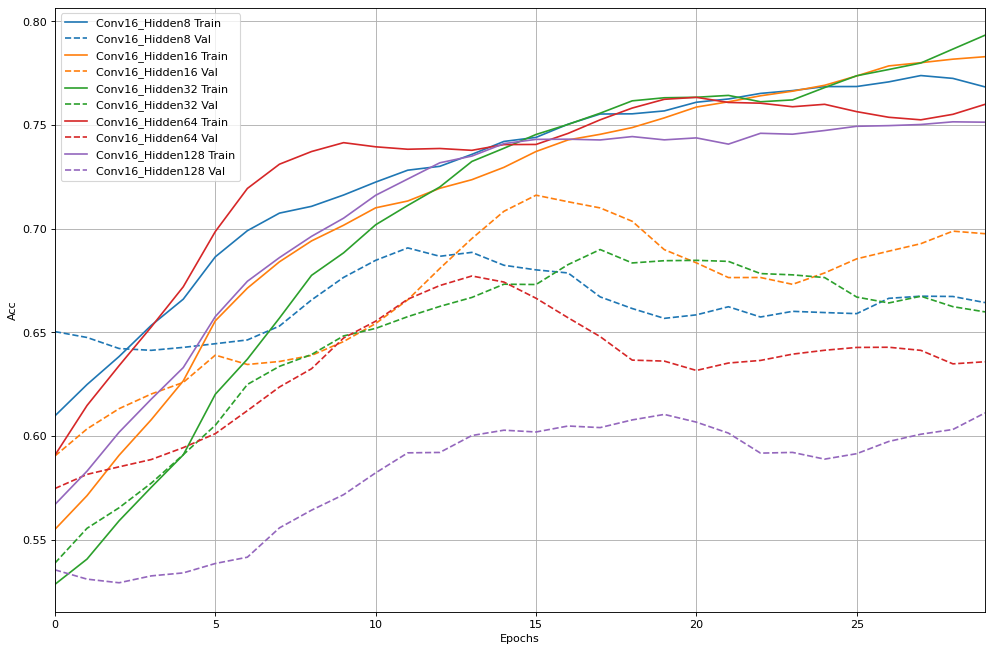

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc', smoothing_std=1)
figure(figsize=(15, 10), dpi=80)

plotter.plot(models_histories)

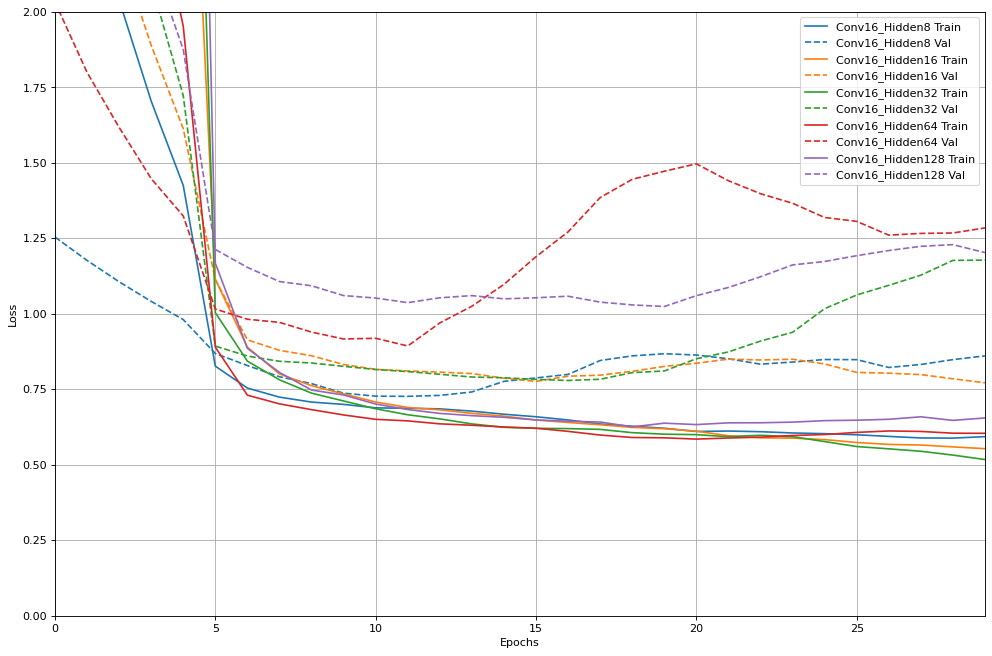

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=1)
figure(figsize=(15, 10), dpi=80)
plt.ylim([0, 2])
plotter.plot(models_histories)